## Practical Lab 3 - Vanilla CNN and Fine-Tune VGG16 - for Dogs and Cats Classification

- Name    : Khushbu Lad - 9027375
- Prof    : Ran Feldesh
- Due date: 26th November,24

### 1. Obtain the Data: Get the Dogs vs Cats dataset

(see class' notebook, only 5000, not 25,000, images are required, these image set is defined in the notebook)
1. Downloaded the dataset
2. Added .data folder in repository and added it into gitignore.
3. Extracted downloaded files into .data folder
4. Path to data is "./dogs-vs-cats/train" and "./dogs-vs-cats/test1" 
5. Compress and divide train data into train, validation and test set as per class notebook

In [2]:
import os, shutil, pathlib

original_dir = pathlib.Path("./.data/dogs-vs-cats/train/")
new_base_dir = pathlib.Path("./.data/dogs-vs-cats/compressed")

In [ ]:
def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=2000)
make_subset("validation", start_index=2000, end_index=4000)
make_subset("test", start_index=4000, end_index=5000)

### 2. EDA: Explore the data with relevant graphs, statistics and insights

##### Verify compressed data directory structure and image counts

In [2]:
for subset in ["train", "validation", "test"]:
    for category in ["cat", "dog"]:
        dir_path = new_base_dir / subset / category
        print(f"{subset}/{category}: {len(os.listdir(dir_path))} images")

train/cat: 2000 images
train/dog: 2000 images
validation/cat: 2000 images
validation/dog: 2000 images
test/cat: 1000 images
test/dog: 1000 images


##### Create train, validation and test dataset using tansorflow

In [3]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 4000 files belonging to 2 classes.
Found 4000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


##### Check average image size

In [3]:
from PIL import Image
import numpy as np

def analyze_image_dimensions(base_dir, subset):
    dimensions = []
    for category in ["cat", "dog"]:
        dir_path = base_dir / subset / category
        for img_name in os.listdir(dir_path):
            img_path = dir_path / img_name
            with Image.open(img_path) as img:
                dimensions.append(img.size)
    
    dimensions = np.array(dimensions)
    print(f"Subset: {subset}")
    print(f"Mean Dimensions: {dimensions.mean(axis=0)}")
    print(f"Min Dimensions: {dimensions.min(axis=0)}")
    print(f"Max Dimensions: {dimensions.max(axis=0)}")

analyze_image_dimensions(new_base_dir, "train")

Subset: train
Mean Dimensions: [402.593 360.018]
Min Dimensions: [59 45]
Max Dimensions: [1023  768]


In [4]:
import pandas as pd

def generate_metadata(base_dir, subset):
    data = []
    for category in ["cat", "dog"]:
        dir_path = base_dir / subset / category
        for img_name in os.listdir(dir_path):
            img_path = dir_path / img_name
            with Image.open(img_path) as img:
                width, height = img.size
            data.append({
                "filename": img_name,
                "category": category,
                "subset": subset,
                "width": width,
                "height": height
            })
    return pd.DataFrame(data)

train_metadata = generate_metadata(new_base_dir, "train")
validation_metadata = generate_metadata(new_base_dir, "validation")
test_metadata = generate_metadata(new_base_dir, "test")

train_metadata.head()


,filename,category,subset,width,height
0,cat.0.jpg,cat,train,500,374
1,cat.1.jpg,cat,train,300,280
2,cat.10.jpg,cat,train,489,499
3,cat.100.jpg,cat,train,403,499
4,cat.1000.jpg,cat,train,150,149


##### Visualize Distribution of Cat and Dog's Images in training set

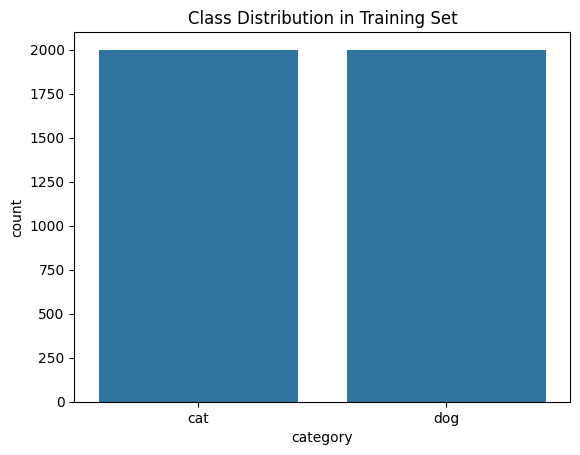

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import get_data_path

# Plot class distribution
sns.countplot(data=train_metadata, x="category")
plt.title("Class Distribution in Training Set")
plt.show()

##### Visualize Distribution of Image's dimensions in training set

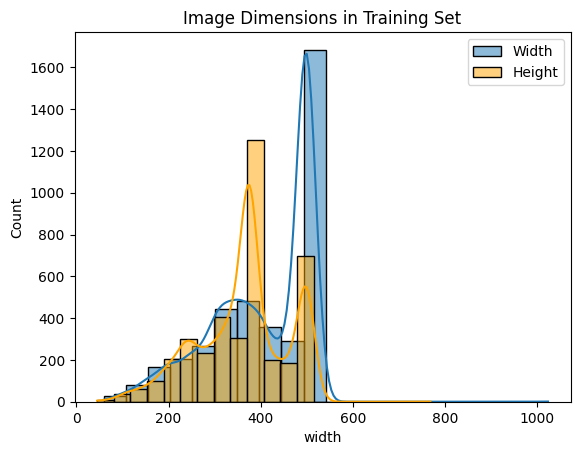

In [7]:
# Plot image dimensions
sns.histplot(data=train_metadata, x="width", bins=20, kde=True, label="Width")
sns.histplot(data=train_metadata, x="height", bins=20, kde=True, color="orange", label="Height")
plt.legend()
plt.title("Image Dimensions in Training Set")
plt.show()

### 3. Train two networks (use callbacks to save the best model version):
1. Define a Neural Network of your choice (3 points)
2. Fine-Tune VGG16 (pre-trained on imagenet). 
Make sure to use validation to test for over-fitting. Plot the appropriate graph

#### Convolutional Neural Networks (CNN)

##### Definition & Summary

In [8]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)


In [9]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │        12,545 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 991,041 (3.78 MB)

 Trainable params: 991,041 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

##### Compile CNN

In [10]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

##### Train CNN

In [15]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=25,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 52s 418ms/step - accuracy: 0.9529 - loss: 0.1265 - val_accuracy: 0.7540 - val_loss: 0.8215
Epoch 2/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 58s 468ms/step - accuracy: 0.9596 - loss: 0.1033 - val_accuracy: 0.7678 - val_loss: 0.9809
Epoch 3/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 65s 522ms/step - accuracy: 0.9717 - loss: 0.0840 - val_accuracy: 0.7483 - val_loss: 1.0179
Epoch 4/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 78s 627ms/step - accuracy: 0.9708 - loss: 0.0760 - val_accuracy: 0.7565 - val_loss: 1.1217
Epoch 5/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 68s 548ms/step - accuracy: 0.9787 - loss: 0.0614 - val_accuracy: 0.7470 - val_loss: 1.2667
Epoch 6/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 67s 536ms/step - accuracy: 0.9763 - loss: 0.0603 - val_accuracy: 0.7577 - val_loss: 1.2285
Epoch 7/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 71s 572ms/step - accuracy: 0.9783 - loss: 0.0734 - val_accuracy: 0.7757 - val_loss: 1.3055
Epoch 8/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 69s 556ms/step - accuracy: 0.9786 - loss: 0

##### Accuracy & Loss

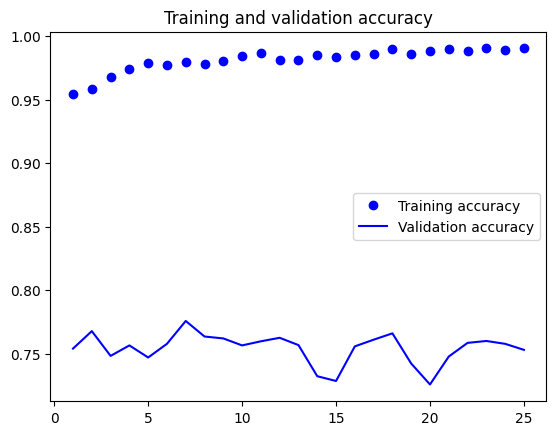

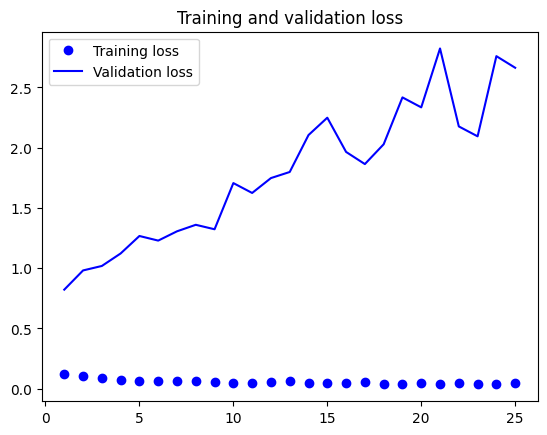

In [16]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### Fine-Tune VGG16 (pre-trained on imagenet).

##### Download pre-trained model and review summary

In [21]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 42s 1us/step


In [22]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 180, 180, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 180, 180, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 90, 90, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 90, 90, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 45, 45, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 45, 45, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 22, 22, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 22, 22, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 11, 11, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 5, 5, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

#### Get features and labels for trained data 

In [23]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

#### Review Shape

In [24]:
train_features.shape

(4000, 5, 5, 512)

#### Define Model

In [28]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(128)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

In [29]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,638,657 (6.25 MB)

 Trainable params: 1,638,657 (6.25 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="./models/feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=30,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8978 - loss: 15.1856 - val_accuracy: 0.9718 - val_loss: 4.3141
Epoch 2/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9814 - loss: 2.6655 - val_accuracy: 0.9743 - val_loss: 4.1239
Epoch 3/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9903 - loss: 1.0913 - val_accuracy: 0.9760 - val_loss: 4.2554
Epoch 4/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9920 - loss: 1.4960 - val_accuracy: 0.9640 - val_loss: 6.7669
Epoch 5/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9894 - loss: 1.9246 - val_accuracy: 0.9765 - val_loss: 4.7510
Epoch 6/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9960 - loss: 0.5228 - val_accuracy: 0.9750 - val_loss: 4.7649
Epoch 7/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9950 - loss: 0.6260 - val_accuracy: 0.9735 - val_loss: 5.7265
Epoch 8/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9963 - loss: 0.3091 - val_accuracy: 0

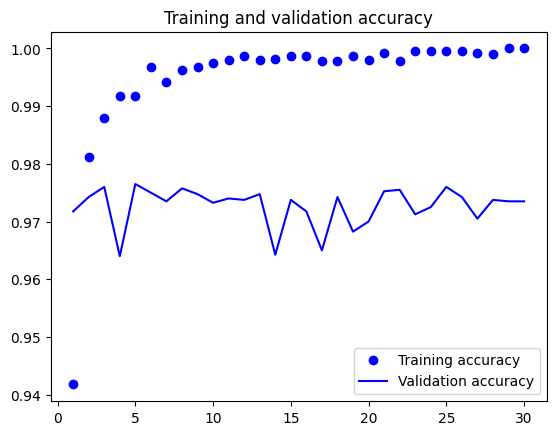

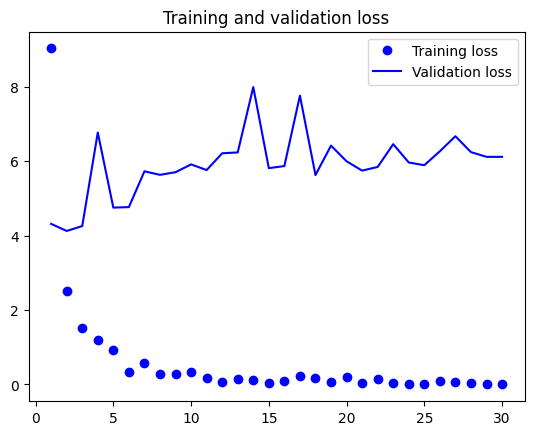

In [31]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### 4. Explore the relative performance of the models (make sure to load the best version of each model) (6 points): 
1. accuracy
2. confusion metric
3. precision, recall, F1-score,
4. precision-recall curve.
5. Explore specific examples in which the model failed to predict correctly.

### 5. Add your conclusions